# Results Analysis

This notebook is intended to read a simulation results file and report the analysis.

In [12]:
%matplotlib inline

import os
import sys 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from networkx.readwrite import json_graph

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.results import Results
from cloudscope.viz import draw_topology
from cloudscope.viz import plot_workload
from cloudscope.viz import plot_message_traffic
from cloudscope.results.analysis import create_per_replica_dataframe as create_dataframe
from cloudscope.results.analysis import create_messages_dataframe

import matplotlib
matplotlib.style.use('ggplot')

In [2]:
# Specify a path to a results file 
FIXTURES = os.path.join("..", "fixtures", "results")
# RESULTS  = os.path.join(FIXTURES, "raft-quorum-20160411.json")
# RESULTS  = os.path.join(FIXTURES, "tagging-quorum-20160411.json")
RESULTS  = os.path.join(FIXTURES, 'federated', "federated-1user-4050T.json")

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        return Results.load(f)

# Load the data
results = get_results_data()

In [3]:
# Create the data frame for further analysis
df = create_dataframe(results)
df 

,committed writes,completed reads,completed writes,dropped write latency,dropped writes,empty reads,mean commit latency (ms),mean message latency (ms),mean read latency (ms),mean visibility latency (ms),mean write latency (ms),reads,recv,replica,sent,stale reads,visible writes,writes,missed reads,visibility ratio
0,78,117,NaN,NaN,40,NaN,1018.661692,30.075652,0,24367.933259,NaN,117,3341,a0,3341,49,38,78,0,0.487179
1,26,69,40,NaN,27,NaN,6822.984960,349.224507,0,33069.730660,0,69,1831,a1,1831,19,13,40,0,0.325000
2,38,48,54,1,38,2,7528.749264,351.285115,0,33181.658053,0,50,1781,a2,1781,9,16,54,2,0.296296
3,46,105,62,NaN,38,3,7347.471427,330.779856,0,28670.508955,0,108,1788,a3,1788,27,24,62,3,0.387097
4,83,121,83,NaN,49,NaN,1127.688942,29.970893,0,30126.967123,0,121,10465,b0,10465,19,34,83,0,0.409639
5,55,118,76,NaN,51,NaN,6849.066132,354.491270,0,32417.810656,0,118,1810,b1,1810,19,25,76,0,0.328947
6,44,71,54,NaN,34,NaN,4451.661246,358.567040,0,31398.405683,0,71,1821,b2,1821,14,20,54,0,0.370370
7,55,102,75,NaN,52,NaN,6298.428535,348.315518,0,30784.047673,0,102,1759,b3,1759,12,23,75,0,0.306667
8,62,80,NaN,NaN,34,NaN,1155.190179,29.954658,0,21525.559013,NaN,80,3385,c0,3385,33,28,62,0,0.451613
9,67,90,87,NaN,57,NaN,6365.597555,336.743016,0,32226.685741,0,90,1827,c1,1827,20,30,87,0,0.344828


# Results 

In [4]:
print results.print_details()

Simulation: Federated Consistency (Cloudscope v0.4)
A large group of eventually consistent nodes in 5 locations with a central core consensus group.

Ran on: Jun 16, 2016 at 17:54 UTC (8 seconds)

Settings
Access Stddev                 180
Do Rumoring                     0
Access Mean                  1200
Move Prob                    0.05
Max Objects Accessed           10
Do Gossip                       1
Max Sim Time              4320000
Random Seed                    42
Switch Prob                   0.1
Election Timeout     [4050, 8100]
Local Prob                    0.6
Heartbeat Interval           2025
Default Consistency        strong
Invalid Types         [u'backup']
Aggregate Heartbeats            1
Sync Prob                     0.3
Read Prob                    0.58
Aggregate Writes                1
Default Latency               800
Anti Entropy Delay           4050
Object Prob                   0.5
Valid Locations      [u'home', u'work', u'mobile', u'cloud']
Session Timeout    

## Topology

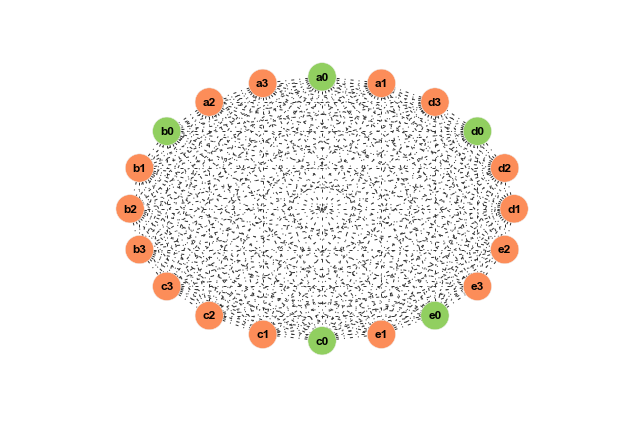

In [5]:
draw_topology(json_graph.node_link_graph(results.topology))

In [6]:
print results.print_topology()

a0: Alpha 0 (alpha-site, strong) 30-175ms connection
a1: Alpha 1 (alpha-site, low) 30-175ms connection
a2: Alpha 2 (alpha-site, low) 30-175ms connection
a3: Alpha 3 (alpha-site, low) 30-175ms connection
b0: Bravo 0 (bravo-site, strong) 30-175ms connection
b1: Bravo 1 (bravo-site, low) 30-175ms connection
b2: Bravo 2 (bravo-site, low) 30-175ms connection
b3: Bravo 3 (bravo-site, low) 30-175ms connection
c0: Charlie 0 (charlie-site, strong) 30-175ms connection
c1: Charlie 1 (charlie-site, low) 30-175ms connection
c2: Charlie 2 (charlie-site, low) 30-175ms connection
c3: Charlie 3 (charlie-site, low) 30-175ms connection
d0: Delta 0 (delta-site, strong) 30-175ms connection
d1: Delta 1 (delta-site, low) 30-175ms connection
d2: Delta 2 (delta-site, low) 30-175ms connection
d3: Delta 3 (delta-site, low) 30-175ms connection
e0: Echo 0 (echo-site, strong) 30-175ms connection
e1: Echo 1 (echo-site, low) 30-175ms connection
e2: Echo 2 (echo-site, low) 30-175ms connection
e3: Echo 3 (echo-site, lo

## Workload

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

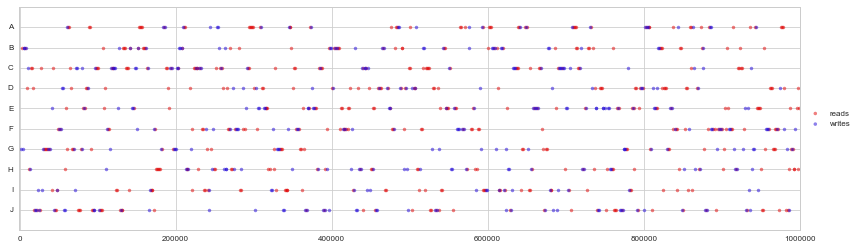

In [7]:
# Create the workload timeline plot 
plot_workload(results, series='objects')

In [8]:
# Create the sent messages timeline
# plot_message_traffic(results.results['sent'])

In [9]:
# Create Message Traffic Data Frame 
def count(nums):
    return sum(nums)
            
msgs = create_messages_dataframe(results)

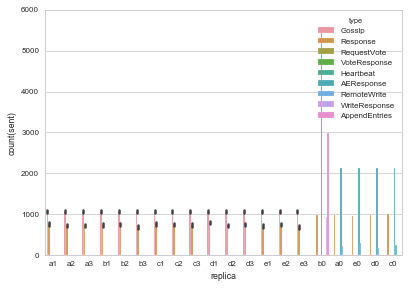

In [10]:
ax = sns.barplot(y='sent', x='replica', hue='type', data=msgs, estimator=count)

## Metrics 

The following metrics are reported from the results.

### Reads and Writes

Accesses
2111 Total Reads, 1481 Total Writes 
105.5 average reads per replica
74.0 average writes per replica



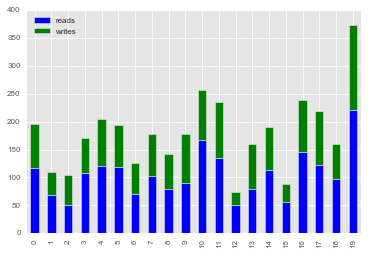

In [13]:
# Extract accesses 
accesses = pd.DataFrame(df, columns=['reads', 'writes'])

print (
    "Accesses\n"
    "========\n"
    "{} Total Reads, {} Total Writes \n"
    "{:0.1f} average reads per replica\n"
    "{:0.1f} average writes per replica\n"
).format(
    df.reads.sum(), df.writes.sum(), df.reads.mean(), df.writes.mean()
)

accesses.plot(kind='bar', stacked=True)

### Stale Reads

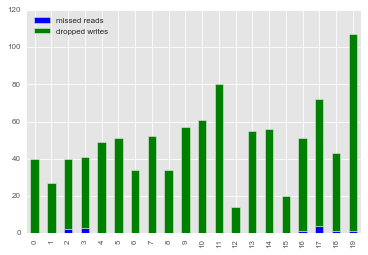

In [14]:
errors = pd.DataFrame(df, columns=['missed reads', 'dropped writes'])
errors.plot(kind='bar', stacked=True)

### Read and Write Costs

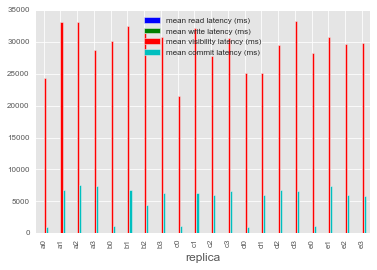

In [15]:
data=pd.DataFrame(df, columns=['replica', 'mean read latency (ms)', 'mean write latency (ms)', 'mean visibility latency (ms)', 'mean commit latency (ms)'])
data.plot(kind='bar', x='replica')